In [2]:
import numpy as np 
import pandas as pd 
from load_and_summarize_data import *
from scipy.optimize import * 
import seaborn as sns
from pandas.tseries.offsets import *
sns.set() 
%matplotlib inline

In [3]:
# Define tickers in consideration: 
# Smaller asset set for testing 
# tickers = ['ES=F', 'ZN=F','DX=F', 'GC=F']
# labels  = ['S&P','10yr', 'Dollar', 'Gold']

# Larger asset set to test effective # of bets
tickers = ['ES=F', 'NQ=F', 'ZN=F', 'ZB=F', '6E=F', '6J=F','GC=F', 'NG=F']
labels  = ['S&P', 'Nasdaq', '10yr', '30yr', 'Euro', 'Yen', 'Gold', 'NatGas']
mapping = dict(zip(tickers, labels))

# Load data for relevant tickers
data = Data(tickers=tickers, start_date='2011-01-02', end_date='2023-03-15')
data.rets.rename(columns=mapping, inplace=True)
data.rets.fillna(0)

[*********************100%***********************]  8 of 8 completed


,Euro,Yen,S&P,Gold,NatGas,Nasdaq,30yr,10yr
Date,,,,,,,,
2011-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-04,-0.004565,-0.004405,0.000000,-0.031000,0.004086,-0.002222,-0.001543,0.001170
2011-01-05,-0.011653,-0.016058,0.005137,-0.003700,-0.041979,0.010799,-0.015198,-0.008961
2011-01-06,-0.010345,0.000500,-0.001179,-0.001456,-0.008719,0.002864,0.005231,0.004849
2011-01-07,-0.006226,0.002913,-0.002165,-0.002115,-0.002706,-0.001428,0.007286,0.007173
...,...,...,...,...,...,...,...,...
2023-03-09,0.002654,0.007405,-0.018773,0.009158,-0.003136,-0.018073,0.004278,0.005093
2023-03-10,0.006287,0.010074,-0.014605,0.017876,-0.044436,-0.013908,0.026560,0.014497
2023-03-13,0.007093,0.015094,-0.001553,0.026692,0.072428,0.007728,0.016353,0.013457


Euro      0.083944
Yen       0.090791
S&P       0.178354
Gold      0.161881
NatGas    0.554266
Nasdaq    0.209646
30yr      0.106196
10yr      0.052028
dtype: float64


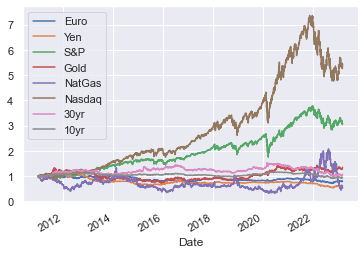

In [4]:
(1 + data.rets).cumprod().plot()
print(data.rets.std(axis=0) * np.sqrt(252))

In [5]:
# Compute a simple trend-following signal using a 21 - 260 day rolling mean 
windows = range(21, 260, 21)

# Define signal matrix
signals = np.empty(shape=(data.rets.shape[0], data.rets.shape[1], len(windows)))

# Loop through each window and compute a simple rolling average signal. Then take the sign
for w_idx, win in enumerate(windows):
    # Compute the rolling average
    roll_avg = data.rets.rolling(window=win, min_periods=round(win/2)).mean()
    signals[:,  :, w_idx] = np.sign(roll_avg)

# Take average across the windows and convert back to dataframe
signals = pd.DataFrame(np.nanmean(signals, axis=2))
signals.index   = data.rets.index 
signals.columns = data.rets.columns

# Weight each signal by the volatility of each market. Use smoothed returns
# to account for market-close times.
smoothed_rets = (np.log(1 + data.rets)).rolling(window=2).sum() / np.sqrt(2)
market_vols   = smoothed_rets.ewm(halflife=126, min_periods=21).std()
vol_adj_sigs  = signals / market_vols

# Compute the "volatility" of the combined signals
port_rets = (vol_adj_sigs.shift(1) * data.rets).sum(axis=1, skipna=False)
port_vols = np.abs(port_rets).ewm(halflife=126, min_periods=21).mean() * np.sqrt(np.pi / 2)
weights   = vol_adj_sigs.div(port_vols.shift(1), axis=0) * 0.1 / np.sqrt(252)

# Compute final returns based on the targeted weights
trend_rets = (weights.shift(1) * data.rets).sum(axis=1, skipna=False)
trend_vols = trend_rets.rolling(window=252, min_periods=126).std() * np.sqrt(252)

/var/folders/lk/0bw5f8_91g79kvbhsk_tqf9h0000gn/T/ipykernel_27055/1422402223.py:14: RuntimeWarning: Mean of empty slice
  signals = pd.DataFrame(np.nanmean(signals, axis=2))


<AxesSubplot: xlabel='Date'>

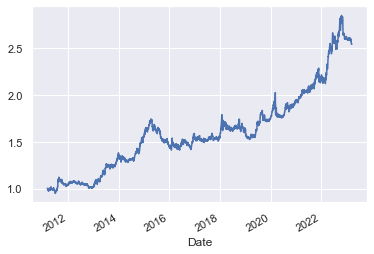

In [6]:
(1 + trend_rets).cumprod().plot()

In [7]:
# Function for computing effective number of bets for a given set of weights
# In this context, we perform PCA using the correlation matrix since we're more 
# interested in the relative covariance among each asset / position rather 
# than the magnitude. For example, we may have a portfolio with assets of 
# wildly different variances, and we do not want a high variance asset to
# necessarily dominate the first PC. 
def compute_enb(w, rho):
    # Produce eigenvalues and eigenvectors
    eig_val, eig_vec = np.linalg.eigh(rho)

    # Sort the elements by decreasing eigenvalues
    # Equivalent is np.argsort(eig_val)[::-1]
    sort_eig = np.argsort(-eig_val)
    eig_val  = eig_val[sort_eig]
    eig_vec  = eig_vec[:, sort_eig]

    # Project the weights using the eigenvectors 
    w_proj = np.linalg.inv(eig_vec).dot(w.T)

    # Compute the contribution to variance from each component
    var_cont  = np.multiply(np.square(w_proj), eig_val)
    prop_cont = var_cont / np.sum(var_cont)

    # Compute effective number of bets
    enb = np.exp(np.dot(-prop_cont, np.log(prop_cont.T)))
    return(enb)


In [8]:
# Compute effective number of bets taken by the trend signal over time. 
enb         = pd.DataFrame(np.zeros(shape=(data.rets.shape[0], 2)))
enb.index   = data.rets.index 
enb.columns = ['Effective Number of Bets', 'Effective Number - Top Day']

# Loop through data
wts_const = weights.iloc[-1, :]
for d_idx, _ in data.rets.iterrows():
    # Get returns over the last year and if there isn't more than 200 days of data, continue
    r_pd = data.rets.loc[d_idx - BDay(500):d_idx, :]
    if r_pd.shape[0] < 200:
        continue

    # Otherwise, compute the correlation matrix and get the weights
    rho = r_pd.corr() 
    wts = weights.loc[d_idx, :]

    # And compute enb
    enb.loc[d_idx, :] = [compute_enb(wts, rho), compute_enb(wts_const, rho)]

<AxesSubplot: xlabel='Date'>

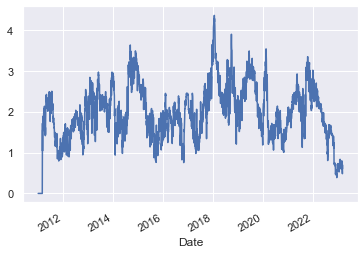

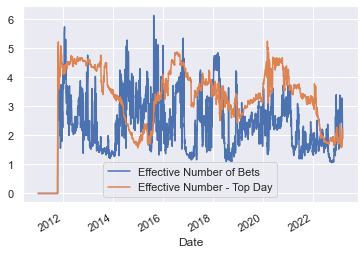

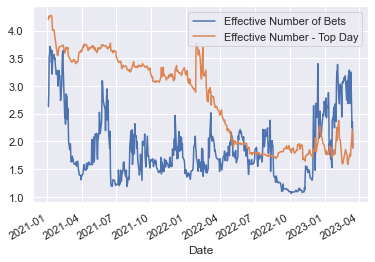

In [9]:
# Note that effective number of bets can fluctuate either as a function of the relationship among
# positions or the signal itself. "Effective Number - Top Day" looks at how the effective number changes
# if you held the positions constant over time. We can see that the recent correlation structure would 
# imply a smaller number of positions recently. 
np.abs(weights).sum(axis=1).plot()
enb.plot()
enb.loc['2021-01-02':].plot()

<AxesSubplot: xlabel='Date'>

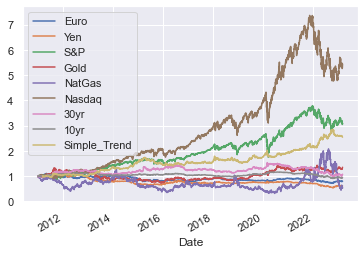

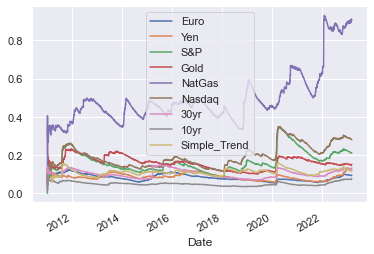

In [10]:
# Append to the list of all returns
data.rets['Simple_Trend'] = trend_rets

# Some quick plots
(1+data.rets).cumprod().plot()
(data.rets.ewm(halflife=126).std() * np.sqrt(252)).plot()


In [11]:
# Define functions used in a simple equal risk-contribution approach

# Compute portfolio variance
def compute_variance(weights, cov_mat):
    weights = np.array(weights)
    return weights.dot(cov_mat).dot(weights.T)

# Compute marginal risk contribution     
def compute_risk_contribution(weights, cov_mat):
    weights  = np.array(weights)
    port_var = compute_variance(weights, cov_mat)
    return (weights.dot(cov_mat) * weights) / port_var

# Define objective function to minimize variability of risk contribution
def objective_ERC(weights, args):
    # Get the marginal risk contributions of the guess
    risk_cont = compute_risk_contribution(weights, args[0])

    # Compute the variance of the risk contribution. Alternatively, we could 
    # do the sum of squared differences from a 1/n guess. 
    return np.var(risk_cont)

In [12]:
# Notional constraint 
def sum_to_one(weights):
    return np.sum(weights) - 1

# Add correlation constraint 
# Note to self: arguments to constraints are passed in individually 
# intsead of as a list or tuple. 
def max_correlation(weights, cov_mat, bench, corr_bound):
    # Compute the covariance between the portfolio and benchmark
    # (Coded the old-fashioned way for more practice)
    weights  = np.array(weights)
    one_hot  = np.zeros(shape=weights.shape)
    one_hot[bench] = 1
    port_cov = weights.dot(cov_mat).dot(one_hot)

    # Compute the vols of the portfolio and benchmark
    port_vol  = np.sqrt(weights.dot(cov_mat).dot(weights.T))
    bench_vol = np.sqrt(one_hot.dot(cov_mat).dot(one_hot.T))

    # Compute the correlation and return constraint 
    # -port_corr + corr_bound >= 0 
    # port_corr <= corr_bound
    port_corr = (port_cov) / (port_vol * bench_vol)
    return -port_corr + corr_bound

# Add a very naive mean return constraint
def mean_return(weights, mu, mu_bound): 
    # Compute average return implied by weights
    weights  = np.array(weights)
    avg_ret  = weights.T.dot(mu)
    
    # Return constraint
    # avg_ret - mu_bound >= 0
    # avg_ret >= mu_bound
    return avg_ret - mu_bound

# Add bounds for non-negativity
num_factors = data.rets.shape[1]
bounds      = tuple((0, 1) for x in range(num_factors))

# Start out with an initial-guess of equal weights
guess = [1 / num_factors for x in range(num_factors)]

In [13]:
# Find beginning of each month to rebalance. Remove indexes with fewer than than 500 days.
rebal_idx = np.where(data.rets.index.is_month_start)[0]
rebal_idx = rebal_idx[rebal_idx > 501] 

In [21]:
# Create an empty set of weights
optim_wts  = pd.DataFrame().reindex_like(data.rets)
sp_col     = data.rets.columns.get_loc("S&P")
corr_bound = 0.25
mu_bound   = 0.01

# Loop through
for _, r_idx in enumerate(rebal_idx):
    # Get returns and compute simple covariance matrix + (annualized) mean vector
    rets_pd = data.rets.iloc[r_idx-500:r_idx, :]
    cov_mat = rets_pd.cov().to_numpy()
    mu_vec  = rets_pd.mean(axis=0).to_numpy() * 252

    # Define arguments for each component
    arguments_corr = [cov_mat, sp_col, corr_bound]
    arguments_opt  = [cov_mat]
    arguments_mn   = [mu_vec, mu_bound]

    # Define constraints
    constraints = ({"type": "eq", "fun": sum_to_one}, 
                   {"type":"ineq", "fun": max_correlation, "args": arguments_corr},
                   {"type":"ineq", "fun": mean_return, "args": arguments_mn})

    optim_res = minimize(objective_ERC, guess, args=arguments_opt, method='SLSQP', bounds=bounds, constraints=constraints)
    optim_wts.iloc[r_idx, :] = optim_res.x

# Forward fill
optim_wts.fillna(inplace=True, method='ffill')
optim_wts = optim_wts.shift(1)

<AxesSubplot: xlabel='Date'>

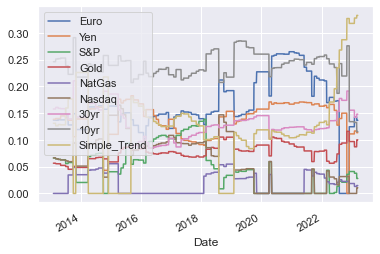

In [22]:
# Define the comparison period 
comp_idx = data.rets.index > data.rets.index[rebal_idx[0]]

# Plot weights 
optim_wts.loc[comp_idx, :].plot()

In [23]:
# Create comparison against equal-weights 
rets_erc  = (optim_wts * data.rets).sum(axis=1)
rets_ew   = (guess * data.rets).sum(axis=1)
rets_comp = pd.concat([rets_ew, rets_erc, data.rets.loc[:, 'S&P']],axis=1)
rets_comp.columns = ['Equal-weight', 'ERC-weight', 'S&P']
rets_comp = rets_comp.loc[comp_idx, :]

# Do correlation of weekly returns
rets_wk   = (1+rets_comp).groupby(pd.Grouper(freq='w')).prod() - 1
rets_wk.corr()

,Equal-weight,ERC-weight,S&P
Equal-weight,1.000000,0.67964,0.558003
ERC-weight,0.679640,1.00000,0.267600
S&P,0.558003,0.26760,1.000000


                AnnRet    AnnVol  SharpeRatio
Equal-weight  0.053472  0.091302     0.585658
ERC-weight    0.023349  0.051873     0.450113
S&P           0.081684  0.187482     0.435688


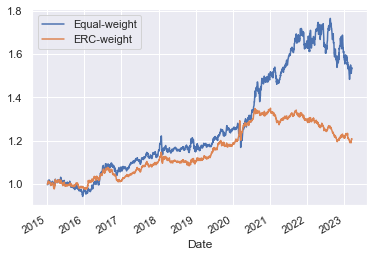

In [24]:
# Plot relative performance
plot_idx = rets_comp.index > '2015-01-02'
(1 + rets_comp.loc[plot_idx, :].iloc[:, :2]).cumprod().plot()
print(compute_summary(rets_comp.loc[plot_idx, :]))

In [18]:
# Look at whole-period risk contribution 
which_wts = [guess, optim_wts]
risk_cont = pd.DataFrame(np.zeros(shape=(optim_wts.shape[1], 2)))
risk_cont.index   = optim_wts.columns 
risk_cont.columns = ['Equal-weight', 'ERC-weight']
for idx, val in enumerate(which_wts):
    wt_rets = val * data.rets
    cov_wts = wt_rets.cov()
    risk_cont.iloc[:, idx] = cov_wts.sum(axis=0) / cov_wts.values.sum()
risk_cont

,Equal-weight,ERC-weight
Euro,0.035884,0.134543
Yen,0.023637,0.151992
S&P,0.111924,0.038373
Gold,0.077686,0.132119
NatGas,0.559995,0.104045
Nasdaq,0.135729,0.051895
30yr,0.021946,0.164264
10yr,0.013013,0.152501
Simple_Trend,0.020185,0.070267


In [19]:
compute_n_drawdowns(pd.DataFrame(rets_comp.iloc[:, 0]), num_dd=5)

,Drawdown,Peak Point,Trough Point,Recovery Point
0,-0.159685,2022-08-16,2023-02-21,Ongoing
1,-0.110753,2014-02-21,2015-12-17,2016-06-28 00:00:00
2,-0.087060,2020-02-18,2020-03-18,2020-04-29 00:00:00
3,-0.081644,2022-04-18,2022-06-30,2022-08-11 00:00:00
4,-0.070980,2018-01-29,2018-02-09,2019-08-13 00:00:00


In [20]:
compute_n_drawdowns(pd.DataFrame(rets_comp.iloc[:, 1]), num_dd=5)

,Drawdown,Peak Point,Trough Point,Recovery Point
0,-0.115799,2021-01-05,2022-10-24,Ongoing
1,-0.069656,2020-03-09,2020-03-19,2020-07-06 00:00:00
2,-0.062539,2014-06-30,2016-01-14,2016-06-15 00:00:00
3,-0.061839,2016-08-18,2016-12-01,2017-07-20 00:00:00
4,-0.053017,2018-01-26,2018-10-30,2019-06-20 00:00:00
